<a href="https://colab.research.google.com/github/abialbon/pytorch-udacity-scholarship/blob/master/CNN/CNN_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [0]:
%matplotlib inline

import torch
from torchvision import datasets, transforms
from torch import nn
import torch.nn.functional as F
from torch import optim
import numpy as np
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [0]:
np.random.seed(42)
from torch.utils.data import SubsetRandomSampler

train_transform = transforms.Compose([transforms.RandomAffine(10),      
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])


transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

trainset = datasets.CIFAR10('/data', train=True, transform=train_transform, download=True)
testset = datasets.CIFAR10('/data', train=False, transform=transform, download=True)

val_fraction = 0.5
i = int(len(testset) * val_fraction)
idx = np.array([x for x in range(len(testset))])
np.random.shuffle(idx)

val_idx, test_idx = SubsetRandomSampler(idx[:i]), SubsetRandomSampler(idx[i:])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
validloader = torch.utils.data.DataLoader(testset, batch_size=32, sampler= val_idx)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, sampler= test_idx)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
def imshow(tensor):
    tensor = (tensor * 0.5) + 0.5
    tensor = tensor.numpy().squeeze()
    tensor = tensor.transpose(1, 2, 0)
    plt.imshow(tensor)
    plt.show()

In [0]:
class ImageClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.c1 = nn.Conv2d(3, 16, 3, padding=1)
        self.c2 = nn.Conv2d(16, 32, 3, padding=1)
        self.c3 = nn.Conv2d(32, 64, 3, padding=1)
        
        self.max_pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(64*4*4, 128)
        self.fc2 = nn.Linear(128, 10)
        
        self.dropout = nn.Dropout(0.2)
        
        
    def forward(self, x):
        x = self.max_pool(F.relu(self.c1(x)))
        x = self.max_pool(F.relu(self.c2(x)))
        x = self.max_pool(F.relu(self.c3(x)))
        x = x.view(-1, 64*4*4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.log_softmax(self.fc2(x), dim=1)
        return x
    
      

In [0]:
model = ImageClassifier()
model.to(device)

ImageClassifier(
  (c1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)

In [0]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [0]:
epochs = 20
val_min = np.inf

for e in range(epochs):
    model.train()
    
    train_loss = 0
    
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        
        output = model.forward(images)
        loss = criterion(output, labels)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    else:
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for images, labels in validloader:
                images, labels = images.to(device), labels.to(device)
                output = model.forward(images)
                loss = criterion(output, labels)
                val_loss += loss.item()
            else:
                avg_val_loss = val_loss/len(validloader)
                print('Epoch: {} ---- Train loss: {:.3f} ---- Val loss: {:.3f}'.format(e+1, train_loss/len(trainloader), avg_val_loss))
                if avg_val_loss < val_min:
                    val_min = avg_val_loss
                    torch.save(model.state_dict(), 'model.pth')
                    print('Model has been saved successfully!')
        

Epoch: 1 ---- Train loss: 1.571 ---- Val loss: 1.301
Model has been saved successfully!
Epoch: 2 ---- Train loss: 1.273 ---- Val loss: 1.121
Model has been saved successfully!
Epoch: 3 ---- Train loss: 1.142 ---- Val loss: 1.052
Model has been saved successfully!
Epoch: 4 ---- Train loss: 1.050 ---- Val loss: 0.919
Model has been saved successfully!
Epoch: 5 ---- Train loss: 0.994 ---- Val loss: 0.922
Epoch: 6 ---- Train loss: 0.952 ---- Val loss: 0.863
Model has been saved successfully!
Epoch: 7 ---- Train loss: 0.915 ---- Val loss: 0.850
Model has been saved successfully!
Epoch: 8 ---- Train loss: 0.885 ---- Val loss: 0.829
Model has been saved successfully!
Epoch: 9 ---- Train loss: 0.860 ---- Val loss: 0.807
Model has been saved successfully!
Epoch: 10 ---- Train loss: 0.845 ---- Val loss: 0.828
Epoch: 11 ---- Train loss: 0.833 ---- Val loss: 0.767
Model has been saved successfully!
Epoch: 12 ---- Train loss: 0.816 ---- Val loss: 0.831
Epoch: 13 ---- Train loss: 0.802 ---- Val loss

In [0]:
with torch.no_grad():
    accuracy = 0
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        output = model.forward(images)
        probs = torch.exp(output)
        p, top_c = probs.topk(1)
        equals = top_c.squeeze() == labels
        equals = equals.type(torch.FloatTensor)
        accuracy += equals.mean()
    print(accuracy/len(testloader) * 100)
    

tensor(75.1393)


In [0]:
l = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

tensor(9)
truck


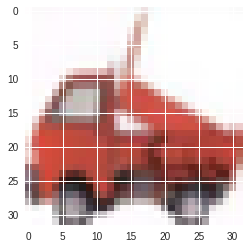

In [0]:
images, labels = iter(testloader).next()

i = images[20]
print(labels[20])
o = model.forward(i.unsqueeze(0).to(device))
p = torch.exp(o)
_, top_c = p.topk(1)

print(l[top_c.item()])
imshow(i)

In [0]:
newmodel = ImageClassifier()
newmodel.load_state_dict(torch.load('model.pth'))

In [0]:
newmodel.cuda()
with torch.no_grad():
    accuracy = 0
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        output = newmodel.forward(images)
        probs = torch.exp(output)
        p, top_c = probs.topk(1)
        equals = top_c.squeeze() == labels
        equals = equals.type(torch.FloatTensor)
        accuracy += equals.mean()
    print(accuracy/len(testloader) * 100)